In [128]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling as pp

sns.set_theme(style = 'whitegrid', font_scale = 2)

In [108]:
def load_and_process(csv1,csv2):

    #Load Data and add columns for "daily gain", "daily volatility" and a blank column "industry" to be filled later to "df"
    
    df = (pd.read_csv(csv1)

            .drop(["volume"], axis =1 )

            .assign(
              daily_gain = lambda x: x["close"]-x["open"],
              daily_volatility = lambda x: x["high"]-x["low"])
         )

    # Load second data set, drop unwanted columns, name column to match other dataframe

    df_industry = (pd.read_csv(csv2)

                   .drop(["Security","SEC filings","Headquarters Location","Date first added","CIK","Founded\n"], axis =1)

                   .rename(columns={"Symbol\n":"Name"})

                  )

    # Cean ticker symbols to match "df"
    df_industry["Name"] = df_industry["Name"].map(lambda x: x.rstrip('\n'))

    #Join the dataframes so that the "GICS Sub-Industry" column from "df_industry" is in "df" and dropna values(stocks that were not presented on both dataframes)
    #Sort values by "Name"
    df2 = (df.join(df_industry.set_index("Name"), on="Name")

             .dropna()

             .sort_values("Name")

          )
    
    return df2

In [109]:
df = load_and_process("../data/raw/all_stocks_5yr.csv","../data/raw/List of stocks by industry.csv")
df

date   open    high     low  close Name  daily_gain  \
71611   2013-02-08  45.07  45.350  45.000  45.08    A        0.01   
72454   2016-06-15  45.11  45.380  44.900  44.94    A       -0.17   
72453   2016-06-14  44.70  44.945  44.560  44.91    A        0.21   
72452   2016-06-13  45.32  45.520  44.905  44.92    A       -0.40   
72451   2016-06-10  45.73  45.780  45.190  45.36    A       -0.37   
...            ...    ...     ...     ...    ...  ...         ...   
618197  2014-10-03  36.87  37.725  36.870  37.67  ZTS        0.80   
618196  2014-10-02  36.58  36.970  36.460  36.91  ZTS        0.33   
618195  2014-10-01  36.87  37.010  36.230  36.45  ZTS       -0.42   
618202  2014-10-10  37.02  37.300  36.640  36.68  ZTS       -0.34   
619039  2018-02-07  72.70  75.000  72.690  73.86  ZTS        1.16   

        daily_volatility  GICS Sector      GICS Sub-Industry  
71611              0.350  Health Care  Health Care Equipment  
72454              0.480  Health Care  Health Care Equipment  
72453              0.385  Health Care  Health Care Equipment  
72452              0.615  Health Care  Health Care Equipment  
72451              0.590  Health Care  Health Care Equipment  
...                  ...          ...                    ...  
618197             0.855  Health Care        Pharmaceuticals  
618196             0.510  Health Care        Pharmaceuticals  
618195             0.780  Health Care        Pharmaceuticals  
618202             0.660  Health Care        Pharmaceuticals  
619039             2.310  Health Care        Pharmaceuticals  

[533800 rows x 10 columns]

In [110]:
df.describe(include = np.number).T

count       mean        std     min     25%     50%  \
open              533800.0  82.419400  82.416793   1.620  41.030  63.410   
high              533800.0  83.159703  83.120747   1.690  41.425  63.970   
low               533800.0  81.669050  81.671904   1.610  40.650  62.865   
close             533800.0  82.441210  82.421750   1.620  41.050  63.430   
daily_gain        533800.0   0.021809   1.425181 -75.810  -0.360   0.025   
daily_volatility  533800.0   1.490653   1.918286  -0.255   0.610   0.990   

                    75%      max  
open              95.62  1477.39  
high              96.43  1498.00  
low               94.80  1450.04  
close             95.64  1450.89  
daily_gain         0.42    81.38  
daily_volatility   1.66   138.26

In [111]:
df.describe(exclude = np.number).T

count unique                    top   freq
date               533800   1259             2018-01-12    433
Name               533800    433                    VAR   1259
GICS Sector        533800     12            Industrials  74146
GICS Sub-Industry  533800    118  Health Care Equipment  20126

## Initial Observations

- The most common Sub-Industry of S&P 500 companies is "Health Care Equipment"
- The "Industrials" Sector is the most common sector
- There are only 433/500 companies in the dataset after combining two seperate sets which imples 67 companies have left the S&P 500 since the data set was published
- There is an extremely high range in minimum and maximum values across all categories. It is probably a good idea to normalize the "daily gain" and "daily_colatility" categories as percentages of the stocks opening or closing price '
- There were 1259 trading days in the five year period where the data was collected

## Potential Questions

- Which Sub-Industry/Sector is most/least volatile on a day to day basis?
- Which Company saw the biggest increase in share price over the 5 year period?
- Does one month see more volatility than others on average?
- Does one month see more growth/loss than others on average?


In [40]:
df.profile_report()

In [112]:
# I am going to scale the "daily volatility" and "daily gain" columns as a percentage of the average of the open and close price for that day.

df["daily_gain%"] = 100*df["daily_gain"]/((df["close"]+df["open"])/2)
df["volatility%"] = 100*df["daily_volatility"]/((df["close"]+df["open"])/2)

In [135]:
#I now will group "GICS Sector" and take the mean of the values
dgps = df.groupby(["GICS Sector"], as_index=False).mean().sort_values(["daily_gain%"], ascending = False)
dgps

GICS Sector        open        high         low       close  \
8     Information Technology   62.428967   63.003789   61.852749   62.456441   
7                Industrials   86.816645   87.554464   86.093927   86.855473   
3           Consumer Staples   70.392629   70.903634   69.889861   70.417371   
11                 Utilities   52.465960   52.862658   52.068242   52.486930   
6                Health Care  104.985527  106.042235  103.907810  105.014166   
5                 Financials   69.962561   70.521842   69.402436   69.984862   
2     Consumer Discretionary   99.099805  100.050983   98.130594   99.109393   
0     Communication Services  119.954501  120.996135  118.844492  119.962740   
1   Communication Services\n   49.001850   49.325505   48.649351   49.008095   
10               Real Estate   92.556953   93.335098   91.745677   92.570418   
9                  Materials   80.486912   81.237490   79.723985   80.502693   
4                     Energy   65.974798   66.726592   65.192856   65.973802   

    daily_gain  daily_volatility  daily_gain%  volatility%  
8     0.027475          1.151040     0.048605     1.954171  
7     0.038828          1.460537     0.043261     1.789626  
3     0.024742          1.013774     0.039030     1.484254  
11    0.020970          0.794416     0.036818     1.601923  
6     0.028639          2.134426     0.036646     1.949880  
5     0.022300          1.119406     0.034159     1.681589  
2     0.009588          1.920389     0.014907     2.022413  
0     0.008240          2.151643     0.014246     2.050894  
1     0.006245          0.676153     0.012809     1.382965  
10    0.013466          1.589421     0.012343     1.731031  
9     0.015782          1.513505     0.008010     2.098865  
4    -0.000996          1.533737    -0.007034     2.491874

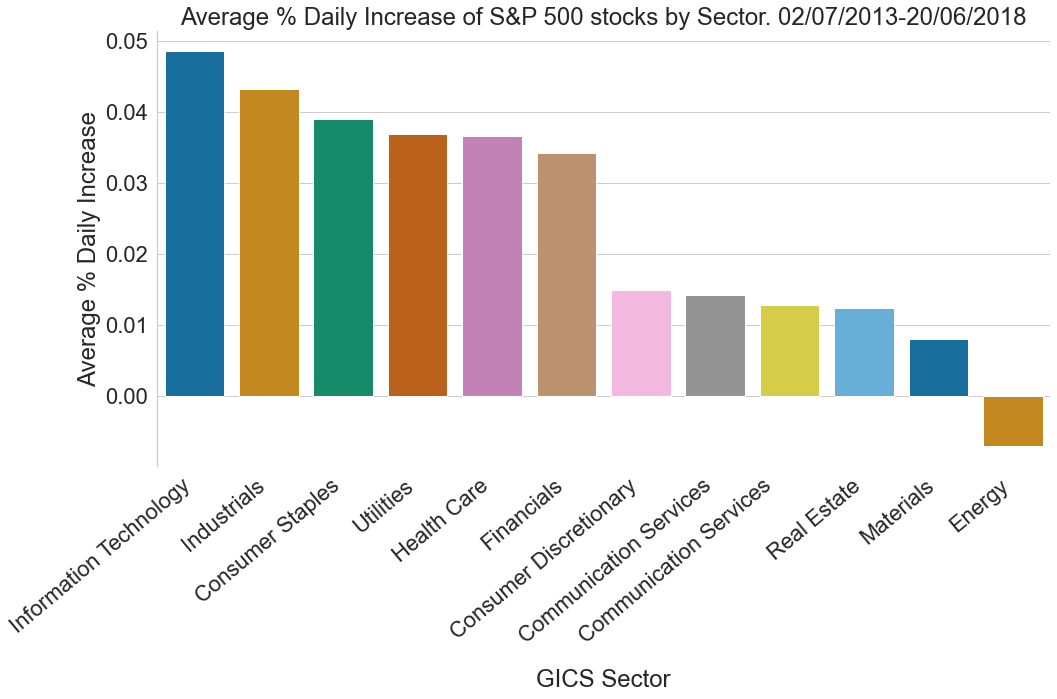

In [136]:
plt.figure(figsize=[16,8])
plot1 = sns.barplot(data = dgps, x="GICS Sector", y="daily_gain%", palette = "colorblind")
sns.despine(bottom =True)
plt.setp(plot1.get_xticklabels(),rotation = 40, horizontalalignment = 'right')
plt.ylabel("Average % Daily Increase")
plt.title("Average % Daily Increase of S&P 500 stocks by Sector. 02/07/2013-20/06/2018").set_position([.5,.5])
plt.show()

## Thoughts

The above is a good visualization of which sectors were the best performing on the 5 year period. It would be better to see the overall average among all stocks across all sectors. I will include this in a future plot. Another problem is that it does not illustrate the variance in daily averages within a sector. 

Next I will explore correlation between volotality percentage and daily gain accross all companies in tha dataset. 

In [125]:
mu_i = df.groupby("Name", as_index = False).mean().sort_values(["daily_gain%"], ascending = False)
mu_i

Name       open       high        low      close  daily_gain  \
198   HPQ  15.912801  16.098331  15.754650  15.938468    0.025667   
197   HPE  17.997475  18.241246  17.797558  18.030878    0.033403   
210  INFO  33.794193  34.125879  33.485688  33.835076    0.040883   
54    BBY  37.854178  38.358002  37.388816  37.895449    0.041271   
296  NVDA  56.316546  57.071319  55.513103  56.369368    0.052822   
..    ...        ...        ...        ...        ...         ...   
42   APTV  89.547841  90.552320  88.538795  89.493864   -0.053977   
233   KMI  29.089816  29.362681  28.768499  29.065814   -0.024002   
156   FCX  20.785035  21.080104  20.462032  20.766370   -0.018665   
274   MRO  23.843816  24.156702  23.500501  23.824635   -0.019181   
386    UA  23.721156  24.055992  23.357280  23.684557   -0.036598   

     daily_volatility  daily_gain%  volatility%  
198          0.343680     0.175943     2.290666  
197          0.443688     0.174769     2.552435  
210          0.640191     0.130414     1.990414  
54           0.969186     0.111516     2.674776  
296          1.558215     0.109048     2.475782  
..                ...          ...          ...  
42           2.013525    -0.069904     2.239637  
233          0.594182    -0.080357     2.209407  
156          0.618072    -0.084946     3.725334  
274          0.656201    -0.089880     3.272047  
386          0.698711    -0.152634     3.042090  

[433 rows x 9 columns]

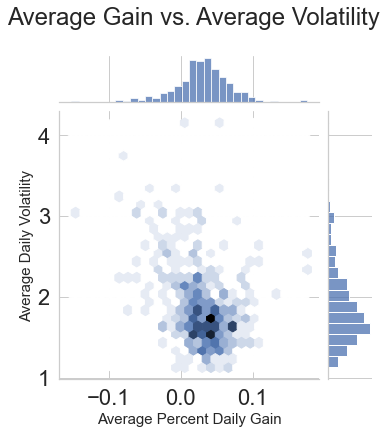

In [163]:
mui_plot = sns.jointplot(data = mu_i, x="daily_gain%", y="volatility%", kind="hex")
mui_plot.set_axis_labels("Average Percent Daily Gain", "Average Daily Volatility", fontsize=15)
plt.title("Average Gain vs. Average Volatility", y=1.3, x=-3)
plt.show()

## Thoughts on the above plot

Unfortunately this plot did not really show what I had hoped for. I was hoping to see a correlation between the average daily increase in stock price and the stocks average volatility. It appears that there is not a clear correlation, however it is interesting to see the distribution of points is most focused around a volatlity percentage between 1 and 2 percent and a daily gain percentage between 0 and 0.1%.

## More Thoughts

I also want to see which sub industry performed the best over the 5 year period. I order to to avoid single day trading prices, I will take the average median trading price over the first week of the 5 year period and the average median trading price over the last week of the 5 year period and compare them. 